In [33]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

from src.utils import load_data

### Load data

In [35]:
X, y, k = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
k_train, k_test = k
print('Training:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTesting:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training:
X-shape: (1676, 38), y-shape: (1676,)

Testing:
X-shape: (419, 38), y-shape: (419,)


##### Prepare data for model.

In [36]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [37]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 3.30027249  7.4228757   4.50567392 14.34175354 15.8096688 ]
first 5 true values: [ 0  9  3 15 23]
MSE: 41.603160892479394


In [38]:
# Test significance in our fit.
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     21.92
Date:                Wed, 26 May 2021   Prob (F-statistic):          2.94e-116
Time:                        14:01:33   Log-Likelihood:                -5376.6
No. Observations:                1676   AIC:                         1.083e+04
Df Residuals:                    1638   BIC:                         1.104e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.827      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.

Therefore, we assume that not all variables will be relevant to include in our hierarchical model. Therefore, we are only interested in keeping a number of the variables.
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [39]:
from sklearn import linear_model

lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
linear_ids = lars.coef_ != 0
linear_ids = np.array([i for i, incl in enumerate(linear_ids) if incl])
print("Include ids: ", linear_ids)

Include ids:  [ 0  1  2  9 10 18 21 27]


In [40]:
X2 = sm.add_constant(X_train[:, linear_ids])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     96.25
Date:                Wed, 26 May 2021   Prob (F-statistic):          1.07e-131
Time:                        14:01:35   Log-Likelihood:                -5395.4
No. Observations:                1676   AIC:                         1.081e+04
Df Residuals:                    1667   BIC:                         1.086e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.692      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [41]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, linear_ids], y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, linear_ids])
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 5.20248878  6.68793155  4.45549343 14.572102   15.24162092]
first 5 true values: [ 0  9  3 15 23]
MSE: 41.434559241549906


### Define model

**Generative Process**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(1)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
     OR Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

We could also try to fit an $r_k$ for each group.


In [42]:
def hierarchical_model(X, linear_ids, k, n_k, obs=None, pred=False):
    
    # Number of observations
    N, n_feat = X[:, linear_ids].shape
    
    # Hyperparameters
    r_gamma1 = 2
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma))
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(n_feat), torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("observations", N):
        psi_mu = torch.sum(X[:, linear_ids] * beta[k], axis=1)
        
        # Sample psi
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [43]:
# Prepare data for Pyro model
if not torch.is_tensor(X_train):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
n_k = len(np.unique(np.concatenate(k)))

In [44]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, linear_ids, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

2000 ELBO: 5101.0: 100%|██████████| 2000/2000 [00:15<00:00, 131.45it/s]

CPU times: user 1min 27s, sys: 3.03 s, total: 1min 30s
Wall time: 15.2 s


##### Visualizations of variable differences from county to county

In [45]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=1000,
                        return_sites=("beta", "r", "pred", "sigma"))
samples = predictive(X_train, linear_ids, k_train, n_k, y_train)
preds = predictive(torch.from_numpy(X_test).float(), linear_ids, k_test, n_k, pred=True)

/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jjn/miniconda3/envs/mbased-ml/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

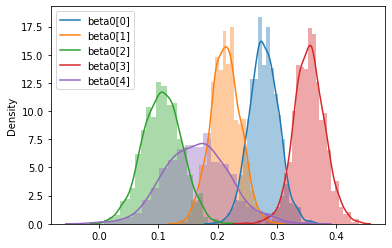

In [46]:
beta_samples = samples["beta"].detach().numpy()
beta_index = 0

for k_ in range(n_k):
    sns.distplot(beta_samples[:,k_,beta_index])
plt.legend(["beta0[%d]" % c for c in range(n_k)])
plt.show()

##### MSE for model

In [48]:
beta = samples["beta"].detach().numpy().mean(axis=0)
r = samples["r"].detach().numpy().mean(axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
print("MSE   (mean):", sum((y_hat - y_test)**2)/len(y_hat))

beta = np.median(samples["beta"], axis=0)
r = np.median(samples["r"], axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_test))

y_hat3 = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat3 - y_test)**2)/len(y_test))

MSE   (mean): 41.25877174899276
MSE (median): 41.232115214158554
MSE (predictive): 40.867648180324785


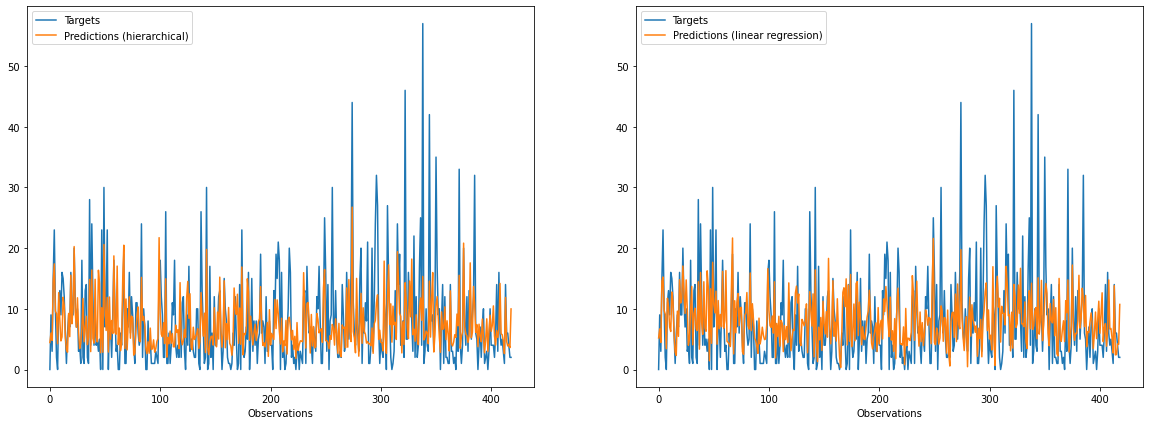

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

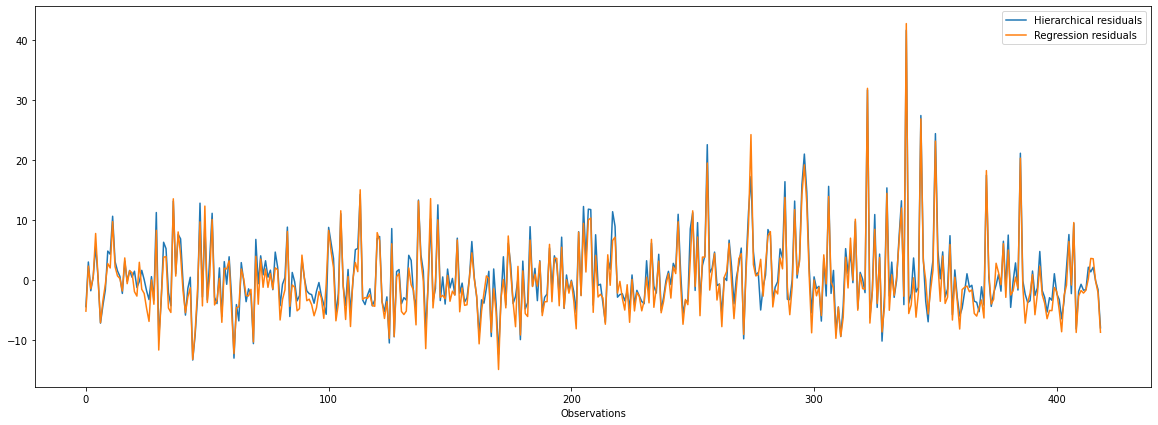

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.plot()

## Try adding Neural Network to hierarchical model

In [51]:
def hierarchical_nn_model(X, linear_ids, k, n_k, obs=None, pred=False):
    # Number of observations
    N, lin_feat = X[:, linear_ids].shape
    nn_feat = X.shape[1]
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Artificial neural network parameters
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(nn_feat, 8), torch.ones(nn_feat, 8)).to_event())
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)).to_event())
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), torch.ones(8, 4)).to_event())
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), torch.ones(4)).to_event())
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), torch.ones(4, 1)).to_event())
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event())
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(lin_feat), torch.ones(lin_feat)).to_event()
        )
    
    with pyro.plate("data", N):
        # Draw for observations.
        # NN forward pass
        x_nn = torch.relu(torch.matmul(X, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        x_nn = torch.matmul(x_nn, w3) + b3

        # Combine non linear and linear features
        lin_contr = torch.sum(X[:, linear_ids] * beta[k], axis=1)
        psi_mu = lin_contr + x_nn.ravel()
        
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [52]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(hierarchical_nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, linear_ids, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5126.8: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]

CPU times: user 2min 43s, sys: 3.21 s, total: 2min 46s
Wall time: 28.1 s


#### Predict with the model

In [54]:
predictive = Predictive(hierarchical_nn_model, guide=nn_guide, num_samples=1000,
                        return_sites=())
samples = predictive(X_train, linear_ids, k_train, n_k)
preds = predictive(torch.from_numpy(X_test).float(), linear_ids, k_test, n_k, pred=True)

In [57]:
beta = samples["beta"].detach().numpy().mean(axis=0)
r = samples["r"].detach().numpy().mean(axis=0)
w1 = samples["w1"].mean(axis=0)
b1 = samples["b1"].mean(axis=0)
w2 = samples["w2"].mean(axis=0)
b2 = samples["b2"].mean(axis=0)
w3 = samples["w3"].mean(axis=0)
b3 = samples["b3"].mean(axis=0)

# NN forward pass 
x_test_nn = torch.tanh(torch.tanh(torch.from_numpy(X_test).float() @ w1 + b1) @ w2 + b2) @ w3 + b3

# Propagate through rest of model
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE (mean):", sum((y_hat - y_test)**2)/len(y_hat))

beta = np.median(samples["beta"].detach().numpy(), axis=0)
r = np.median(samples["r"].detach().numpy(), axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_hat))

y_hat3 = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat3 - y_test)**2)/len(y_test))

MSE (mean): 41.54261033098231
MSE (median): 41.55272781252274
MSE (predictive): 41.111116100797766


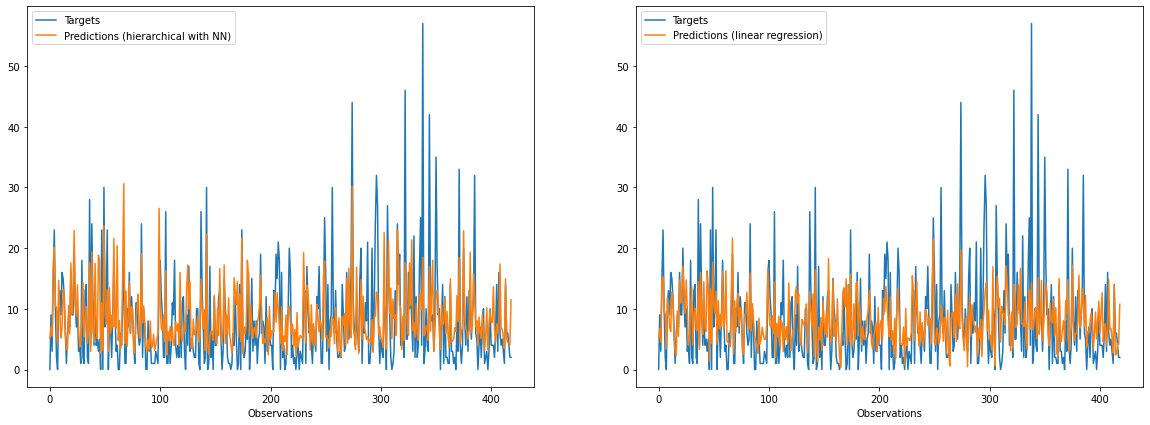

In [58]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat3, label="Predictions (hierarchical with NN)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

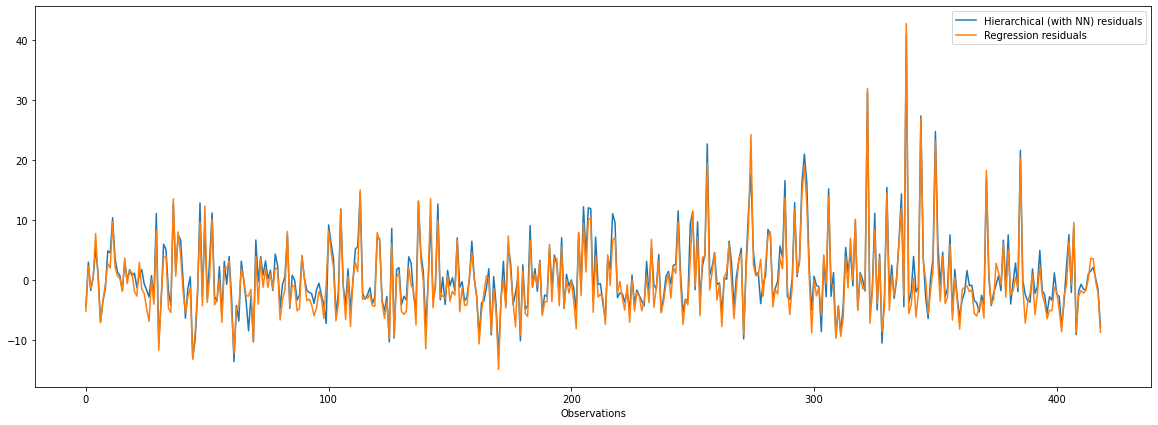

In [59]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical (with NN) residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.plot()